# Setup

In [1]:
#installing necessary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, 
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
#expanding column view since my dataset has a comprehensive NOTES section
pd.options.display.max_colwidth = 3000 

In [3]:
df = pd.read_csv("data/USA_Full.csv")

In [5]:
#checking things out
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56008 entries, 0 to 56007
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EVENT_ID_CNTY       56008 non-null  object 
 1   EVENT_DATE          56008 non-null  object 
 2   YEAR                56008 non-null  int64  
 3   TIME_PRECISION      56008 non-null  int64  
 4   DISORDER_TYPE       56008 non-null  object 
 5   EVENT_TYPE          56008 non-null  object 
 6   SUB_EVENT_TYPE      56008 non-null  object 
 7   ACTOR1              56008 non-null  object 
 8   ASSOC_ACTOR_1       41667 non-null  object 
 9   INTER1              56008 non-null  int64  
 10  ACTOR2              5506 non-null   object 
 11  ASSOC_ACTOR_2       2227 non-null   object 
 12  INTER2              56008 non-null  int64  
 13  INTERACTION         56008 non-null  int64  
 14  CIVILIAN_TARGETING  614 non-null    object 
 15  ISO                 56008 non-null  int64  
 16  REGI

# Explore

In [6]:
df['DISORDER_TYPE'].value_counts()

Demonstrations                        52799
Strategic developments                 2524
Political violence                      533
Political violence; Demonstrations      152
Name: DISORDER_TYPE, dtype: int64

In [7]:
#Boolean masking for only disorder that involves demonstrations
demonstrations =['Demonstrations','Political violence; Demonstrations'] 
df = df[df['DISORDER_TYPE'].isin(demonstrations)]

In [8]:
#will binary code our target-- Peaceful protest:0, all others:1
df['SUB_EVENT_TYPE'].value_counts() 

Peaceful protest                      50437
Protest with intervention              1314
Violent demonstration                  1048
Excessive force against protesters      152
Name: SUB_EVENT_TYPE, dtype: int64

# Define Target

In [9]:
# Creating my binary target
def map_target(category):
    # Non-violent categories
    violent = ['Protest with intervention', 'Violent demonstration','Excessive force against protesters']
    
    # Check if the category is in the violent list
    if category in violent:
        return 1
    else:
        return 0

# Create new column 'is_violent'
df['is_violent'] = df['SUB_EVENT_TYPE'].apply(map_target)

# Display the DataFrame
print(df[['SUB_EVENT_TYPE', 'is_violent']])

         SUB_EVENT_TYPE  is_violent
0      Peaceful protest           0
1      Peaceful protest           0
2      Peaceful protest           0
3      Peaceful protest           0
4      Peaceful protest           0
...                 ...         ...
56003  Peaceful protest           0
56004  Peaceful protest           0
56005  Peaceful protest           0
56006  Peaceful protest           0
56007  Peaceful protest           0

[52951 rows x 2 columns]


In [11]:
#about 5% of our documented demonstrations involved violence or arrest
df['is_violent'].value_counts(normalize = True) 

0    0.952522
1    0.047478
Name: is_violent, dtype: float64

# After looking through many Notes, Tags, and Associated Actors, I notice certain recurring values I want to account for

In [12]:
# define a function to match keywords to tags, labels, and strings
def contains_keyword(text, keywords):
    return any(keyword.lower() in str(text).lower() for keyword in keywords)

# Groups--
## Religious Groups

In [13]:
#tags in ASSOC_ACTOR columns
religious_keywords_actor = ['Christian Group','Muslim Group','Jewish Group'] 
#keywords in NOTES columns
religious_keywords_notes= ['christian','muslim','jewish']

# Creating a new binary column
df['religious'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], religious_keywords_actor) 
                                            or contains_keyword(row['NOTES'], religious_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], religious_keywords_actor)), axis=1)
print(df['religious'].value_counts())

0    50072
1     2879
Name: religious, dtype: int64


## Labor

In [14]:
labor_keywords_actor = ['Labor Group']
labor_keywords_notes= ['strike', 'picket']

df['labor'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], labor_keywords_actor) 
                                            or contains_keyword(row['NOTES'], labor_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], labor_keywords_actor)), axis=1)
df['labor'].value_counts()

0    45732
1     7219
Name: labor, dtype: int64

## Educational Groups (Students and Teachers)

In [15]:
ed_keywords_actor = ['Students', 'Teachers']
ed_keywords_notes= ['Students', 'Teachers']

df['education'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], ed_keywords_actor) 
                                            or contains_keyword(row['NOTES'], ed_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], ed_keywords_actor)), axis=1)
df['education'].value_counts()

0    43929
1     9022
Name: education, dtype: int64

## Journalists

In [16]:
journ_keywords_actor = ['Journalist']

df['journalists'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], ed_keywords_actor) 
                                            or contains_keyword(row['ASSOC_ACTOR_2'], ed_keywords_actor)), axis=1)
df['journalists'].value_counts()

0    44390
1     8561
Name: journalists, dtype: int64

## Hate Groups

In [17]:
# First read csv file from Southern Poverty Law Center which monitors hate groups
# (many have a hyphen separating local chapter, so split on '-' and keep 0 index)
df_hate = pd.read_csv('data/splc-hate-groups-2022.csv')
df_hate['MainGroup'] = df_hate['Title'].apply(lambda x: x.split('-')[0].strip()) 


# Get unique main group names
unique_main_groups = df_hate['MainGroup'].unique()

# Convert the array of unique values to a list
splc_hate_list = list(unique_main_groups)
# The ACLED list comes from their website. Consists of most prominent hate groups in 2023
acled_hate_list = ['QAnon','Oath Keepers','Boogaloo','American Contingency','III%', 'WLM',
                   'white lives matter','Proud Boys', 'Patriot Front','Goyim Defense League',
                   'Patriot Prayer', 'Civilian Defense Force','Light Foot Militia']

hate_keywords_actor = acled_hate_list
hate_keywords_notes= splc_hate_list

df['hate'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], hate_keywords_actor) 
                                            or contains_keyword(row['NOTES'], hate_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], hate_keywords_actor)), axis=1)
print(df['hate'].value_counts())


0    45418
1     7533
Name: hate, dtype: int64


## Anarchists/Antifa

In [18]:
#below are tags in ASSOC_ACTOR column, I did not choose them
antifa_keywords_actor = ['antifa', 'anarchist group', 'abolish ice'] 
antifa_keywords_notes= ['antifa', 'antifascist', 'anti-fascist', 'anti fascist', 'fascism', 'anarchist', 'abolish ICE']

df['antifa'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], antifa_keywords_actor) 
                                            or contains_keyword(row['NOTES'], antifa_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], antifa_keywords_actor)), axis=1)
print(df['antifa'].value_counts())


0    52394
1      557
Name: antifa, dtype: int64


# Motivators--
## Abortion

In [21]:
#Women is the TAG used by ACLED for these
ab_keywords_actor = ['Women', 'Planned Parenthood'] 
ab_keywords_notes= ['Roe ', 'abortion', 'reproductive', 'Planned Parenthood', 'Dobbs']

df['abortion'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], ab_keywords_actor) 
                                            or contains_keyword(row['NOTES'], ab_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], ab_keywords_actor)), axis=1)
df['abortion'].value_counts()

0    46660
1     6291
Name: abortion, dtype: int64

## Immigration

In [22]:
immi_keywords_actor = ['Migrants']
immi_keywords_notes= ['migrants', 'immigration', 'immigrants']

df['immigration'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], immi_keywords_actor) 
                                            or contains_keyword(row['NOTES'], immi_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], immi_keywords_actor)), axis=1)
df['immigration'].value_counts()

0    51946
1     1005
Name: immigration, dtype: int64

## Climate

In [23]:
clim_keywords_actor = ['climate', 'Extinction Rebellion']
clim_keywords_notes= ['climate']

df['climate'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], clim_keywords_actor) 
                                            or contains_keyword(row['NOTES'], clim_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], clim_keywords_actor)), axis=1)
df['climate'].value_counts()

0    52086
1      865
Name: climate, dtype: int64

## Black Lives Matter

In [24]:
blm_keywords_actor = ['BLM']
blm_keywords_notes= ['BLM', 'black lives matter', 'racial justice']

# Create new column
df['BLM'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], blm_keywords_actor) 
                                            or contains_keyword(row['NOTES'], blm_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_1'], blm_keywords_actor)), axis=1)


print(df['BLM'].value_counts())

0    40142
1    12809
Name: BLM, dtype: int64


## LGBT

In [25]:
lgbt_keywords_actor = ['LGBT']
lgbt_keywords_notes= ['LGBT','gay', 'trans ', 'transgender', 'drag ', 'drag queen', 'lesbian']

df['LGBT'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], lgbt_keywords_actor) 
                                            or contains_keyword(row['NOTES'], lgbt_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], lgbt_keywords_actor)), axis=1)
print(df['LGBT'].value_counts())

0    50861
1     2090
Name: LGBT, dtype: int64


## Confederate Statues

In [26]:
confederate_keywords_actor = ['confederate']
confederate_keywords_notes= ['confederate', 'statue', 'statues']

df['confederate'] = df.apply(lambda row: int(contains_keyword(row['ASSOC_ACTOR_1'], confederate_keywords_actor) 
                                            or contains_keyword(row['NOTES'], confederate_keywords_notes)
                                            or contains_keyword(row['ASSOC_ACTOR_2'], confederate_keywords_actor)), axis=1)
print(df['confederate'].value_counts())


0    52369
1      582
Name: confederate, dtype: int64


# MISC -- 
## Armed Groups Present

In [27]:
armed_keywords_tags = ['armed'] #'TAGS' column contains tag for whether demonstration had openly armed groups

df['armed'] = df.apply(lambda row: int(contains_keyword(row['TAGS'], armed_keywords_tags)), axis=1)

print(df['armed'].value_counts())

0    52206
1      745
Name: armed, dtype: int64


## Counterprotesters Present

In [28]:
#ACLED actually has a numerical code (66) for two opposing groups of protesters present at a demonstration
#as well as a specific tag ('counter-demonstration') in column 'TAGS'

counterprotest_keywords_tags = ['counter-demonstration']
counterprotest_value_INTERACTION = 66 

df['counterprotest'] = df.apply(lambda row: int(contains_keyword(row['TAGS'], counterprotest_keywords_tags) 
                                                or row['INTERACTION'] == counterprotest_value_INTERACTION), axis=1)
print(df['counterprotest'].value_counts())


0    50582
1     2369
Name: counterprotest, dtype: int64


## Vehicle-involved
### (many of the violent demonstrations involved cars, either vandalized or lone wolf driving into crowds)

In [29]:
# Define the keywords you want to search for
vehicle_keywords = ['drive', 'drove', 'driver', 'driving',' car ', ' truck ', ' motorcycle ']

df['vehicle_involved'] = df.apply(lambda row: int(contains_keyword(row['NOTES'], vehicle_keywords)), axis=1)

print(df['vehicle_involved'].value_counts())

0    51074
1     1877
Name: vehicle_involved, dtype: int64


# New features engineered. Moving on to dates and crowd size

In [30]:
# Convert EVENT_DATE to datetime
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])

# Extract year, month, and day as separate features
df['year'] = df['EVENT_DATE'].dt.year
df['month'] = df['EVENT_DATE'].dt.month
df['day'] = df['EVENT_DATE'].dt.day

# Converting Crowd Size to numerical and removing NaNs

In [31]:
#Crowd-size is indicated in the 'TAGS' column, not all rows in the 'TAGS' column has values, so coding them as 
#'crowd size=no report'

#define function to isolate the crowd tag from other tags
def extract_crowd_size(tags):
    # check if tags is a string
    if isinstance(tags, str):
        # Split the tags string into individual tags
        tags_list = tags.split(';')
        
        # iterate through the tags in 'TAGS' column
        for tag in tags_list:
            tag = tag.strip()
            if tag.lower().startswith("crowd size"):
                return tag
    # if no value in tag column, fill with "no report"
    return 'crowd size=no report'

In [32]:
df['crowd_size'] = df['TAGS'].apply(extract_crowd_size)
df['crowd_size'].value_counts().head(50)

crowd size=no report            25259
crowd size=hundreds              3395
crowd size=dozens                3298
crowd size=more than 100         1050
crowd size=about 100              943
crowd size=about 50               814
crowd size=about 200              530
crowd size=about 30               509
crowd size=about 20               436
crowd size=thousands              418
crowd size=about a dozen          377
crowd size=about 40               362
crowd size=over 100               358
crowd size=more than 50           329
crowd size=several hundred        306
crowd size=small                  287
crowd size=about 150              267
crowd size=more than 200          265
crowd size=several dozen          254
crowd size=about two dozen        241
crowd size=about 60               238
crowd size=about 300              213
crowd size=a small group          211
crowd size=around 100             209
crowd size=more than a dozen      206
crowd size=several                191
crowd size=n

In [45]:
df['crowd_size'].isna().sum()

0

In [33]:
#manually mapping values of the 50 most frequently occuring crowd-size keys
custom_mapping = {
    'crowd size=no report': np.nan,
    'crowd size=hundreds': 200,
    'crowd size=dozens':24,
    'crowd size=more than 100': 110,
    'crowd size=about 100': 100,
    'crowd size=about 50': 50,              
    'crowd size=about 200': 200,             
    'crowd size=about 30': 30,               
    'crowd size=about 20': 20,               
    'crowd size=thousands':2000, 
    'crowd size=about a dozen': 12,        
    'crowd size=about 40':40,             
    'crowd size=over 100': 115,
    'crowd size=more than 50': 55,
    'crowd size=several hundred': 300,
    'crowd size=small': 10,   
    'crowd size=about 150': 150, 
    'crowd size=more than 200': 210,
    'crowd size=several dozen':48,
    'crowd size=about two dozen':24,
    'crowd size=about 60': 60,
    'crowd size=about 300': 300,
    'crowd size=a small group': 10,
    'crowd size=around 100': 100,
    'crowd size=more than a dozen':15,
    'crowd size=several': 5,
    'crowd size=nearly 100':95,
    'crowd size=a few dozen':36,
    'crowd size=about 75':75,
    'crowd size=about 25':25,
    'crowd size=around 50':50,
    'crowd size=more than 300':305,
    'crowd size=about 70':70,
    'crowd size=about 15': 15,
    'crowd size=around 200':200,
    'crowd size=a few hundred': 300,
    'crowd size=a group': np.nan,
    'crowd size=more than 30': 35,
    'crowd size=about 500': 500,
    'crowd size=more than 1000':1020,
    'crowd size=more than 150': 155,
    'crowd size=over 200': 205,
    'crowd size=nearly 200': 195,
    'crowd size=at least 100': 105,
    'crowd size=a handful': 5,
    'crowd size=over 50': 55,
    'crowd size=around 30': 30,
    'crowd size=about 80': 80,
    'crowd size=about 1000': 1000,
    'crowd size=about 250': 250,
    'crowd size=about 400': 400,
    'crowd size=over 1000': 1010,
}

# define function to apply the custom mapping
def map_crowd_size(crowd_size_string):
    return custom_mapping.get(crowd_size_string, np.nan)

# Creating a new column with numerical values for crowd_size
df['crowd_size_numerical'] = df['crowd_size'].apply(map_crowd_size)

# display DataFrame
print(df[['crowd_size', 'crowd_size_numerical']])


                  crowd_size  crowd_size_numerical
0       crowd size=no report                   NaN
1       crowd size=no report                   NaN
2       crowd size=no report                   NaN
3       crowd size=no report                   NaN
4       crowd size=no report                   NaN
...                      ...                   ...
56003      crowd size=dozens                  24.0
56004   crowd size=no report                   NaN
56005   crowd size=no report                   NaN
56006   crowd size=no report                   NaN
56007  crowd size=roughly 30                   NaN

[52951 rows x 2 columns]


In [34]:
#Creating a new DataFrame deepcopy with non-NaN crowd_size_numerical values called df1
df1 = df[df['crowd_size_numerical'].notna()].copy(deep = True)

In [35]:
print(df1['is_violent'].value_counts(normalize= True))
#In the culling, we have the same approximate % of target values as before

print(df1.shape)
#we also still have very many datapoints

0    0.953051
1    0.046949
Name: is_violent, dtype: float64
(18467, 52)


# MODELING TIME

In [38]:
col_list = ['year','ADMIN1', 'crowd_size_numerical',  #ADMIN1 CORRESPONDS TO U.S. STATE
            'vehicle_involved', 'religious', 'labor', 'abortion', 'education',
            'journalists', 'immigration', 'climate', 'BLM', 'LGBT', 'hate', 
            'antifa', 'confederate', 'armed','counterprotest']
X = df1[col_list]
y = df1['is_violent']

In [39]:
#defining our different preprocessing columns
binary_cols = ['vehicle_involved', 'religious', 'labor', 'abortion', 'education','journalists', 
               'immigration', 'climate', 'BLM', 'LGBT', 'hate', 'antifa', 'confederate', 
               'armed', 'counterprotest']
cat_cols = ['ADMIN1', 'year']
num_cols = ['crowd_size_numerical']

# LogisticRegression with GridCV

In [40]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num_standard', StandardScaler(), num_cols),
        ('num_maxabs', MaxAbsScaler(), binary_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

In [41]:
# Instantiate the Logistic Regression
logreg = LogisticRegression(max_iter=1000,random_state=42)

# hyperparameter Grid to search in GridCV
params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['none','l2']
}

# Combine preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler()),
    ('classifier', logreg)
])
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_logreg = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_logreg.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_logreg.best_params_)

# Use best estimator for predictions and evaluation
best_logreg = cv_logreg.best_estimator_
y_pred = best_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

Best parameters found:  {'classifier__C': 100, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3522
           1       0.12      0.78      0.21       172

    accuracy                           0.73      3694
   macro avg       0.55      0.75      0.53      3694
weighted avg       0.95      0.73      0.81      3694


    confusion matrix: 
 [[2571  951]
 [  38  134]]


In [42]:
# Instantiate the Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# hyperparameter Grid to search in GridCV
params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['none','l2']
}

# Combine preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE()),
    ('classifier', logreg)
])
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_logreg = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_logreg.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_logreg.best_params_)

# Use best estimator for predictions and evaluation
best_logreg = cv_logreg.best_estimator_
y_pred = best_logreg.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

Best parameters found:  {'classifier__C': 100, 'classifier__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      3522
           1       0.12      0.77      0.21       172

    accuracy                           0.72      3694
   macro avg       0.55      0.75      0.52      3694
weighted avg       0.94      0.72      0.80      3694


    confusion matrix: 
 [[2538  984]
 [  39  133]]


# RANDOM FOREST with GridCV

In [43]:
# Instantiate the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)


# hyperparameter Grid to search in GridCV
params = {
    'classifier__n_estimators': [100, 200], 
    'classifier__max_depth': [None, 10, 20], 
    'classifier__min_samples_split': [2, 5], 
    'classifier__min_samples_leaf': [1, 4], 
    'classifier__bootstrap': [True], 
    'classifier__max_features': ['auto'] 
}

# preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE()),
    ('classifier', rf_clf)
])
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_rfclf = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_rfclf.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_rfclf.best_params_)

# Use best estimator for predictions and evaluation
best_rfclf = cv_rfclf.best_estimator_
y_pred = best_rfclf.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3522
           1       0.13      0.62      0.22       172

    accuracy                           0.79      3694
   macro avg       0.55      0.71      0.55      3694
weighted avg       0.94      0.79      0.85      3694


    confusion matrix: 
 [[2825  697]
 [  66  106]]


# RandomForest with GridCV on different params

In [44]:
# Instantiate the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)


# hyperparameter Grid to search in GridCV
params = {
    'classifier__n_estimators': [300], 
    'classifier__max_depth': [3, 4, 5], 
    'classifier__min_samples_split': [2,3], 
    'classifier__min_samples_leaf': [3,4], 
    'classifier__bootstrap': [True], 
    'classifier__max_features': ['auto'] 
}

# preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE()),
    ('classifier', rf_clf)
])
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_rfclf = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_rfclf.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_rfclf.best_params_)

# Use best estimator for predictions and evaluation
best_rfclf = cv_rfclf.best_estimator_
y_pred = best_rfclf.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 3, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3522
           1       0.12      0.72      0.20       172

    accuracy                           0.73      3694
   macro avg       0.55      0.72      0.52      3694
weighted avg       0.94      0.73      0.81      3694


    confusion matrix: 
 [[2578  944]
 [  49  123]]


/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  w

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  w

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  w

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/forrestwilliams/anaconda3/envs/wheely

# K-NearestNeighbors GridCV

In [66]:
# Instantiate the RandomForestClassifier
knn_clf = KNeighborsClassifier()

# hyperparameter Grid to search in GridCV
params = {
    'classifier__n_neighbors': [7,10],
    'classifier__weights': ['uniform','distance'],
    'classifier__algorithm': ['auto'],
    'classifier__p': [1, 2],
}

#vvvv The Parameters below were taking way too long, so I canceled the process and used above ^^^

# params = {
#     'classifier__n_neighbors': [3, 5, 7, 10],
#     'classifier__weights': ['uniform', 'distance'],
#     'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'classifier__p': [1, 2],
#     'classifier__leaf_size': [30, 40, 50]
# }


# preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE()),
    ('classifier', knn_clf)
])
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_knnclf = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_knnclf.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_knnclf.best_params_)

# Use best estimator for predictions and evaluation
best_knnclf = cv_knnclf.best_estimator_
y_pred = best_knnclf.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

Best parameters found:  {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 10, 'classifier__p': 2, 'classifier__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3522
           1       0.10      0.33      0.15       172

    accuracy                           0.83      3694
   macro avg       0.53      0.59      0.53      3694
weighted avg       0.92      0.83      0.87      3694


    confusion matrix: 
 [[3024  498]
 [ 116   56]]


# XGBoost GridCV

In [67]:
# Instantiate the RandomForestClassifier
xgb_clf = XGBClassifier(random_state=42)


# hyperparameter Grid to search in GridCV
params = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.1, 0.5, 1],
    'classifier__max_depth': [3, 5, 8],
    'classifier__colsample_bytree': [0.5, 1]
}


# preprocessor, oversampling method, and model into a pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE()),
    ('classifier', xgb_clf)
])
# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the grid search cross-validation
cv_xgbclf = GridSearchCV(estimator=pipeline, param_grid=params, 
                  cv=5, scoring='recall', n_jobs=-1)

# Fit the model
cv_xgbclf.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", cv_xgbclf.best_params_)

# Use best estimator for predictions and evaluation
best_xgbclf = cv_xgbclf.best_estimator_
y_pred = best_xgbclf.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

Best parameters found:  {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3522
           1       0.13      0.63      0.22       172

    accuracy                           0.79      3694
   macro avg       0.55      0.71      0.55      3694
weighted avg       0.94      0.79      0.85      3694


    confusion matrix: 
 [[2812  710]
 [  64  108]]


# XGBoost with different gridCV params 
## (this is where I realized I don't have to include all the above code every time)

In [69]:
# Calculate the ratio of negative class to positive class
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.5, 0.7, 1],
    'classifier__colsample_bytree': [0.5, 0.7, 1],
    'classifier__scale_pos_weight': [1, ratio, ratio * 2]
}
cv_xgbclf.fit(X_train, y_train)

print("Best parameters found: ", cv_xgbclf.best_params_)

# Use best estimator for predictions and evaluation
best_xgbclf = cv_xgbclf.best_estimator_
y_pred = best_xgbclf.predict(X_test)
print(classification_report(y_test, y_pred))

print("""
    confusion matrix: \n\
""", confusion_matrix(y_test,y_pred))

Best parameters found:  {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3522
           1       0.13      0.62      0.21       172

    accuracy                           0.79      3694
   macro avg       0.55      0.71      0.55      3694
weighted avg       0.94      0.79      0.85      3694


    confusion matrix: 
 [[2807  715]
 [  66  106]]


# Making a ROC-AUC graph to show the efficiency of my various tuned models

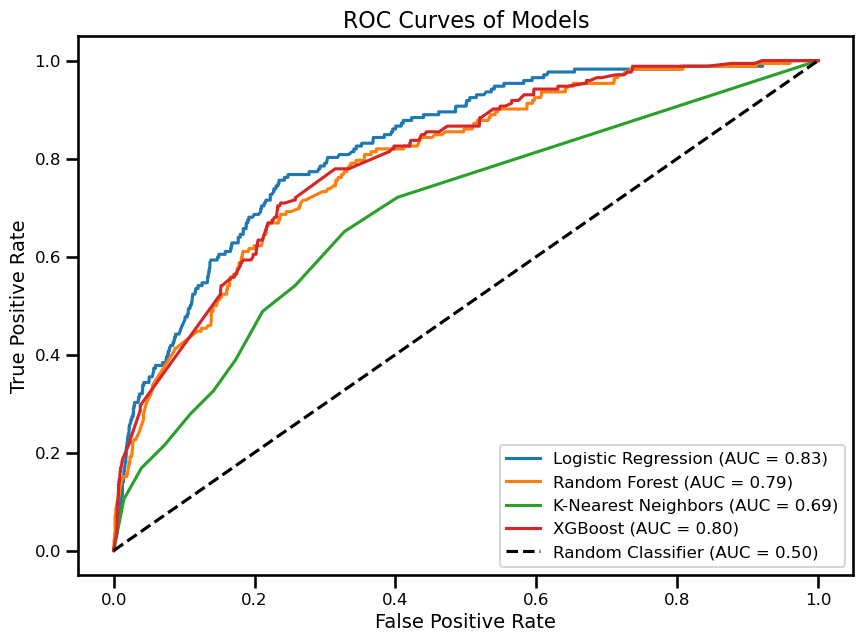

In [142]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Mapping my best trained models of each classifier
models = {
    'Logistic Regression': best_logreg,
    'Random Forest': best_rfclf,
    'K-Nearest Neighbors': best_knnclf,
    'XGBoost': best_xgbclf
}

# Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 7))

# Calculating the ROC curve and AUC-ROC, then plotting it
for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plotting a random classifier for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Setting plot labels and title with larger fonts
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves of Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


# Visualizing Weights--

## Years

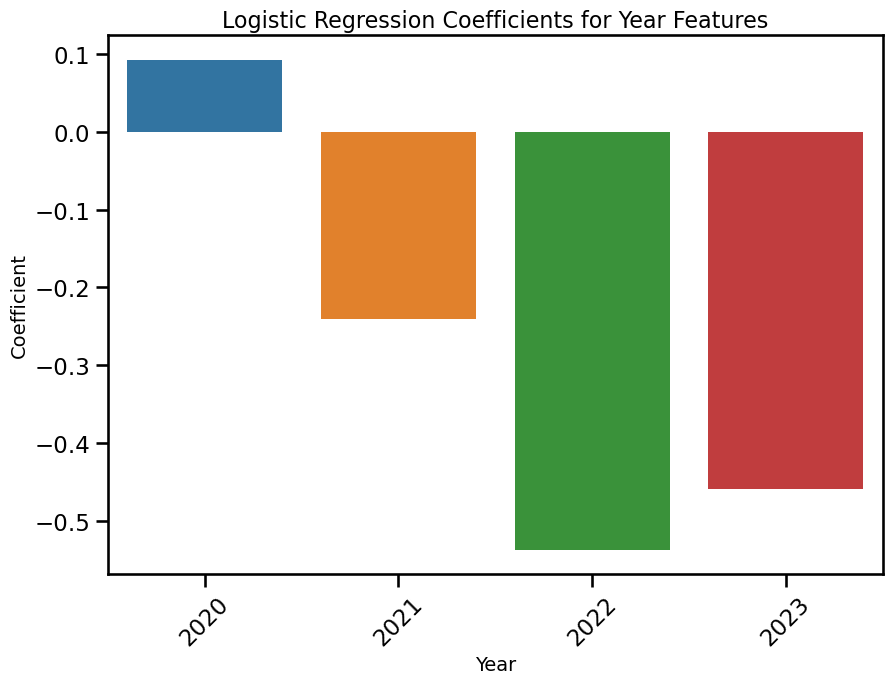

In [141]:
# Extract coefficients
logreg_model = best_logreg.named_steps['classifier']
coefs = logreg_model.coef_[0]

# Extract feature names
one_hot_feature_names = best_logreg.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=['ADMIN1', 'year'])

# Filtered coefficients for each year
year_feature_names = [name for name in one_hot_feature_names if 'year' in name]
year_feature_indices = [list(one_hot_feature_names).index(name) for name in year_feature_names]
year_coefs = coefs[len(num_cols) + len(binary_cols):][year_feature_indices]

# Extract just the year part from the feature names using splitting from '_' and last part
extracted_years = [name.split('_')[-1] for name in year_feature_names]

# Create DataFrame for seaborn
df = pd.DataFrame({
    'Year': extracted_years,
    'Coefficient': year_coefs
})

# Set the font scale to be good for a presentation
sns.set_context("talk", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})

# Plot bar graph for years in seaborn because it's prettiest
plt.figure(figsize=(10, 7))
sns.barplot(x='Year', y='Coefficient', data=df, orient='v')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coefficient", fontsize=14)
plt.title("Logistic Regression Coefficients for Year Features", fontsize=16)
plt.xticks(rotation=45)
plt.show()


# Binary-Coded Columns Created in Feature Engineering

In [98]:
print(list(X.columns)) #want to change the names to what they represent, rather than column title

['year', 'ADMIN1', 'crowd_size_numerical', 'vehicle_involved', 'religious', 'labor', 'abortion', 'education', 'journalists', 'immigration', 'climate', 'BLM', 'LGBT', 'hate', 'antifa', 'confederate', 'armed', 'counterprotest']


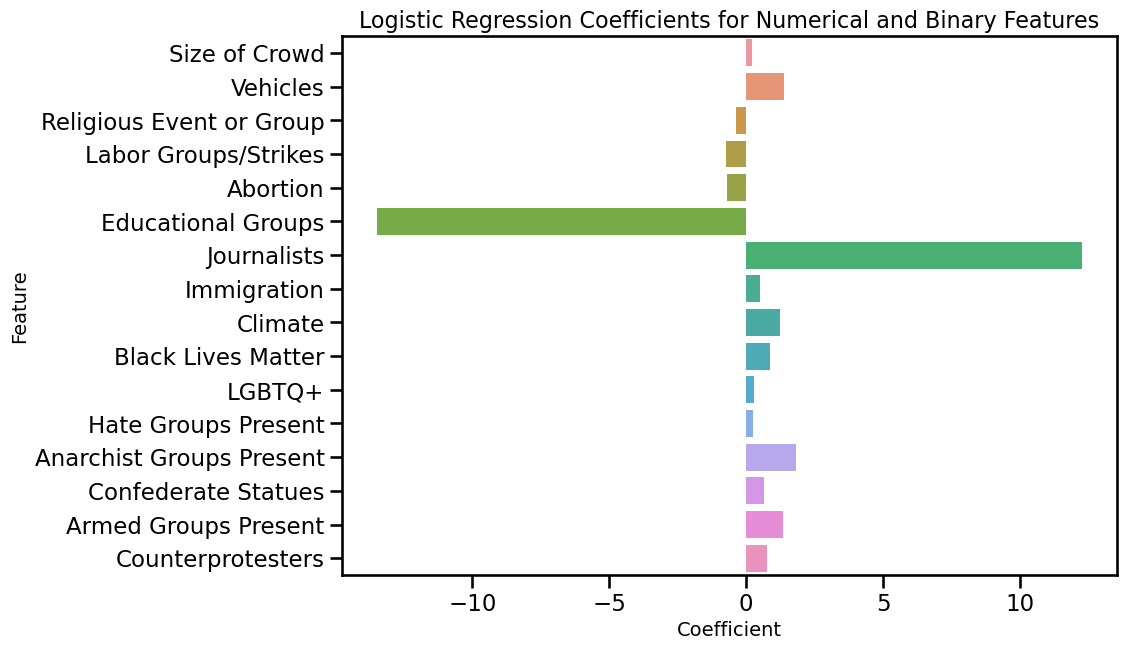

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract coefficients
logreg_model = best_logreg.named_steps['classifier']  # Get the logistic regression model from my pipeline
coefs = logreg_model.coef_[0]  # Get the associated coefficients

# Define feature names
num_cols = ['crowd_size_numerical']
binary_cols = ['vehicle_involved', 'religious', 'labor', 'abortion', 'education',
               'journalists', 'immigration', 'climate', 'BLM', 'LGBT', 'hate', 
               'antifa', 'confederate', 'armed', 'counterprotest']

# Split the coefficients for numerical and binary features
num_binary_coefs = coefs[:len(num_cols) + len(binary_cols)]

# mapping feature names to what they actually represent
feature_name_mapping = {
    'crowd_size_numerical': 'Size of Crowd',
    'vehicle_involved': 'Vehicles',
    'religious': 'Religious Event or Group',
    'labor': 'Labor Groups/Strikes',
    'abortion':'Abortion', 
    'education': 'Educational Groups', 
    'journalists':'Journalists', 
    'immigration':'Immigration', 
    'climate':'Climate', 
    'BLM':'Black Lives Matter', 
    'LGBT':'LGBTQ+', 
    'hate':'Hate Groups Present', 
    'antifa':'Anarchist Groups Present', 
    'confederate': 'Confederate Statues', 
    'armed':'Armed Groups Present', 
    'counterprotest':'Counterprotesters',
}

# Map feature names
descriptive_feature_names = [feature_name_mapping.get(name, name) for name in num_cols + binary_cols]

# font set to presentation size
sns.set_context("talk", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})

# Create DataFrame of features and coefficients
df = pd.DataFrame({
    'Feature': descriptive_feature_names,
    'Coefficient': num_binary_coefs
})

# Plot features
plt.figure(figsize=(10, 7))
sns.barplot(x='Coefficient', y='Feature', data=df, orient='h')
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients for Numerical and Binary Features")
plt.show()


# Creating Hypothetical Values for New York and North Carolina

In [112]:
# hypothetical data NY
hypothetical_protest = pd.DataFrame([{
    'crowd_size_numerical': 200,
    'vehicle_involved': 0,
    'religious': 0,
    'labor': 0,
    'abortion':0, 
    'education':0, 
    'journalists':0, 
    'immigration':0, 
    'climate':0, 
    'BLM':0, 
    'LGBT':1, 
    'hate':1, 
    'antifa':0, 
    'confederate':0, 
    'armed':0, 
    'counterprotest':1,
    'year': 2023,
    'ADMIN1': 'New York'
}])

#predict_proba on hypothetical stats
predicted_probabilities = best_logreg.predict_proba(hypothetical_protest)

# define variable to predicted probability
probability_of_violence = predicted_probabilities[0][1]  

print(f"Predicted probability of violence: {probability_of_violence:.2f}")


Predicted probability of violence: 0.67


In [121]:
#Hypothetical stats same as above, but for North Carolina
hypothetical_protest = pd.DataFrame([{
    'crowd_size_numerical': 200,
    'vehicle_involved': 0,
    'religious': 0,
    'labor': 0,
    'abortion':0, 
    'education':0, 
    'journalists':0, 
    'immigration':0, 
    'climate':0, 
    'BLM':0, 
    'LGBT':1, 
    'hate':1, 
    'antifa':0, 
    'confederate':0, 
    'armed':0, 
    'counterprotest':1,
    'year': 2023,
    'ADMIN1': 'North Carolina'
}])

#same process as above cell
predicted_probabilities = best_logreg.predict_proba(hypothetical_protest)
probability_of_violence = predicted_probabilities[0][1] 
print(f"Predicted probability of violence: {probability_of_violence:.2f}")


Predicted probability of violence: 0.73


# Plotting Confusion Matrix

<Figure size 800x800 with 0 Axes>

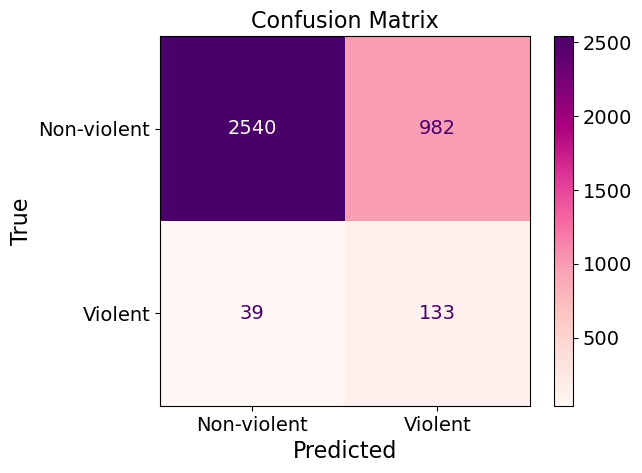

In [135]:
# Presentation-sized font
plt.rcParams['font.size'] = 14

#y predictions on test data
y_pred = best_logreg.predict(X_test)

#set variable to confusion matrix of tests v predicted
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-violent', 'Violent'])

# Using red-purple colormap
plt.figure(figsize=(8, 8))
disp.plot(cmap='RdPu')  

# title and labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)

# Show plot
plt.show()

# Reset the font size to default
plt.rcParams['font.size'] = plt.rcParamsDefault['font.size']


# Visualizing the probability distribution histogram of the data in the top right quadrant of ConfusionMatrix-- Model predicted violent, but actually non-violent

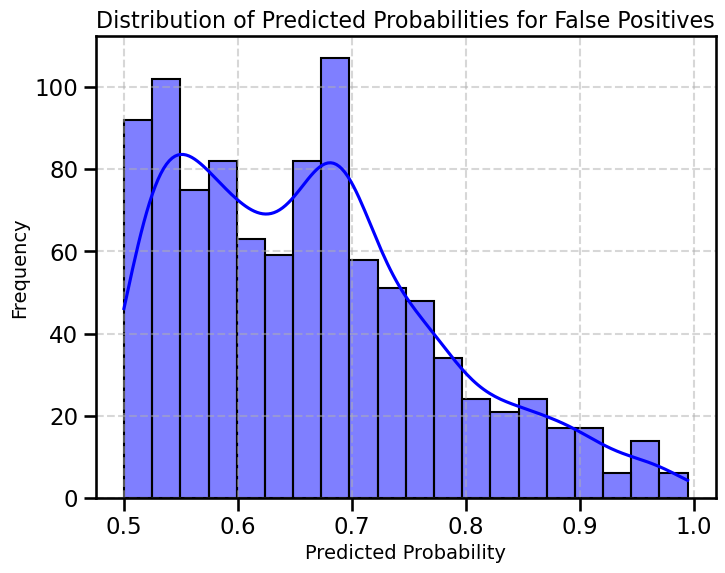

In [143]:

# Presentation-sized font
plt.rcParams['font.size'] = 14

# predicted probabilities for X_test predicted 1
predicted_probabilities = best_logreg.predict_proba(X_test)[:, 1]

# set variable to predictions
predictions = best_logreg.predict(X_test)

# set variable probabilities for false positives (actually non-violent, predicted violent)
false_positive_probs = predicted_probabilities[(y_test == 0) & (predictions == 1)]

# Plot histogram using seaborn
plt.figure(figsize=(8, 6))
sns.histplot(false_positive_probs, bins=20, kde=True, color='blue')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities for False Positives")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Visualizing weights of 10 most positively and negatively correlated US States

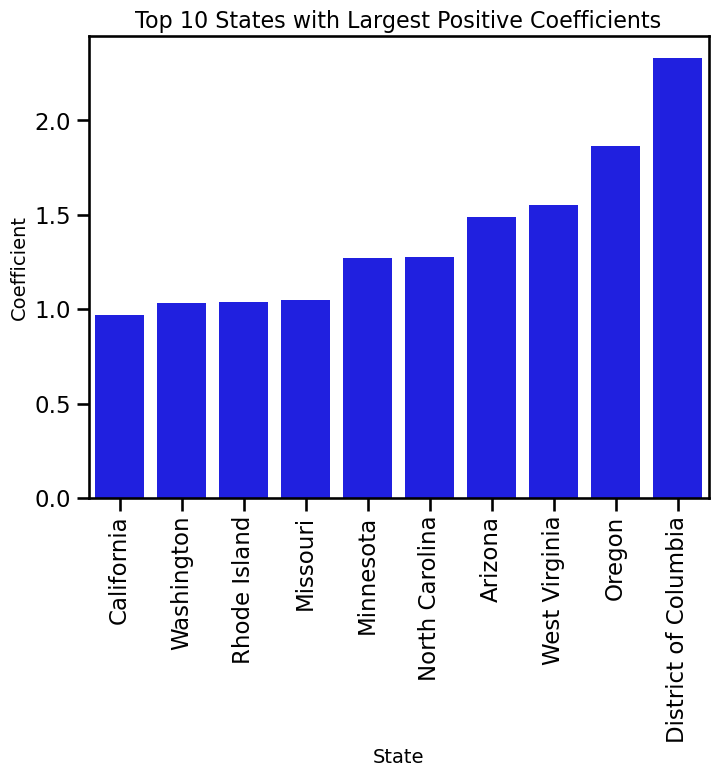

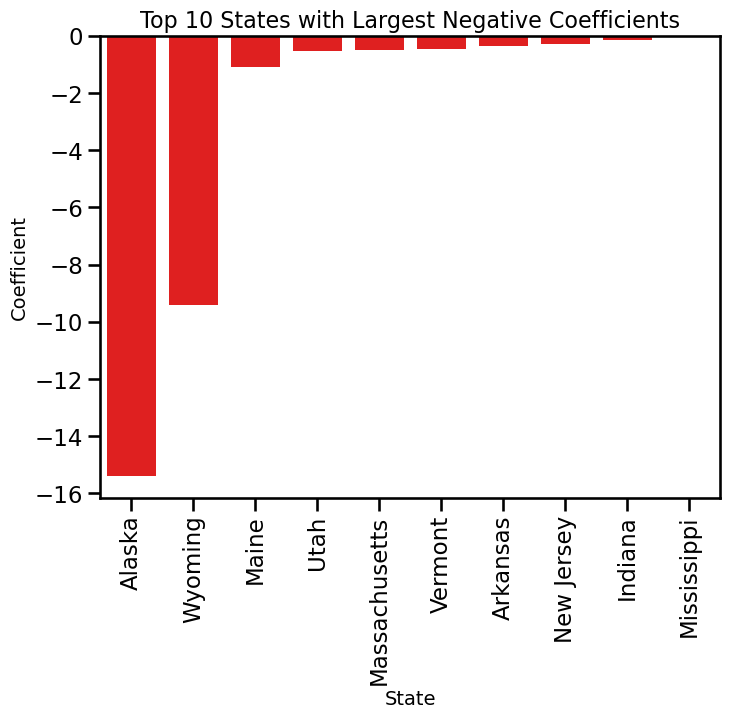

In [144]:
# get coefficients
logreg_model = best_logreg.named_steps['classifier']  
coefs = logreg_model.coef_[0]  

plt.rcParams['font.size'] = 14

# get feature names OUT
one_hot_feature_names = best_logreg.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=['ADMIN1', 'year'])
state_feature_names = [name.split('_')[1] for name in one_hot_feature_names if 'ADMIN1' in name]

# get coefficients for states
state_coefs = coefs[len(num_cols) + len(binary_cols):]

# zipping state names with coefficients
state_coefs_with_names = sorted(list(zip(state_feature_names, state_coefs)), key=lambda x: x[1])

# top states positive and negative
top_positive = state_coefs_with_names[-10:]
top_negative = state_coefs_with_names[:10]

# top 10 positive coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=[name for name, coef in top_positive], y=[coef for name, coef in top_positive], color='blue')
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Coefficient")
plt.title("Top 10 States with Largest Positive Coefficients")
plt.show()

# top 10 negative coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=[name for name, coef in top_negative], y=[coef for name, coef in top_negative], color='red')
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Coefficient")
plt.title("Top 10 States with Largest Negative Coefficients")
plt.show()
